<a href="https://colab.research.google.com/github/TurMod/Data-Science-HW/blob/main/Hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [2]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [3]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Sequential
from keras.metrics import Precision, Recall, F1Score

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.5),

    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy", Precision(), Recall(), F1Score()]
)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0


history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, y_test),
)

Epoch 1/20
469/469 [==============================] - 66s 134ms/step - loss: 0.5912 - accuracy: 0.7852 - precision: 0.8609 - recall: 0.7128 - f1_score: 0.7833 - val_loss: 0.4225 - val_accuracy: 0.8518 - val_precision: 0.8867 - val_recall: 0.8115 - val_f1_score: 0.8483
Epoch 2/20
469/469 [==============================] - 48s 103ms/step - loss: 0.4001 - accuracy: 0.8554 - precision: 0.8864 - recall: 0.8248 - f1_score: 0.8545 - val_loss: 0.3589 - val_accuracy: 0.8693 - val_precision: 0.8946 - val_recall: 0.8481 - val_f1_score: 0.8702
Epoch 3/20
469/469 [==============================] - 49s 105ms/step - loss: 0.3486 - accuracy: 0.8731 - precision: 0.8967 - recall: 0.8494 - f1_score: 0.8723 - val_loss: 0.3140 - val_accuracy: 0.8875 - val_precision: 0.9089 - val_recall: 0.8687 - val_f1_score: 0.8859
Epoch 4/20
469/469 [==============================] - 47s 101ms/step - loss: 0.3188 - accuracy: 0.8832 - precision: 0.9043 - recall: 0.8640 - f1_score: 0.8827 - val_loss: 0.2885 - val_accuracy:

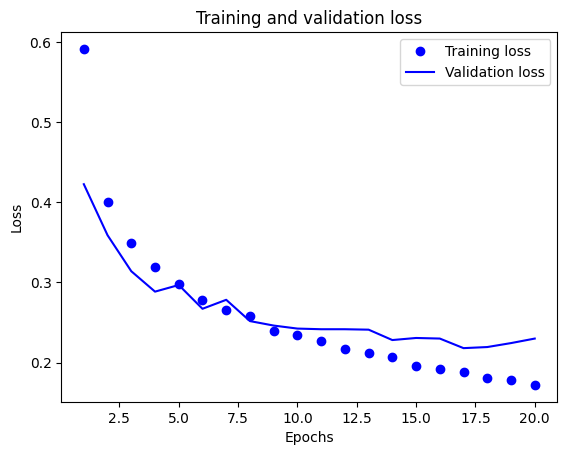

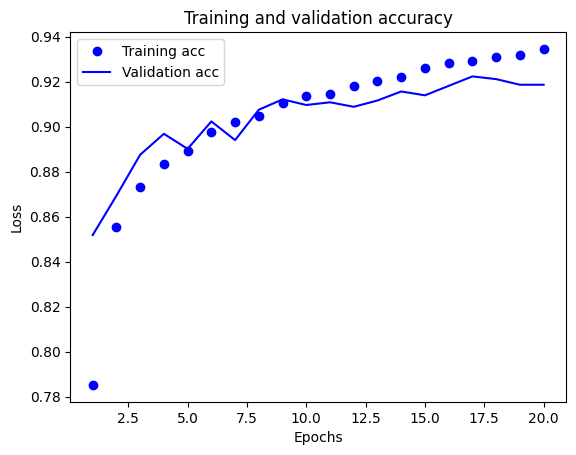

In [6]:
import matplotlib.pyplot as plt


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [7]:
results = model.evaluate(x_test, y_test)
print(results)

313/313 [==============================] - 3s 9ms/step - loss: 0.2300 - accuracy: 0.9186 - precision: 0.9258 - recall: 0.9123 - f1_score: 0.9180
[0.23000872135162354, 0.9186000227928162, 0.9258169531822205, 0.9122999906539917, array([0.86389965, 0.9883897 , 0.8761905 , 0.9265593 , 0.87569207,
       0.9824032 , 0.74773335, 0.966193  , 0.9819096 , 0.9711684 ],
      dtype=float32)]


Згорткова нейромережа має кращі результати ніж звичайна багатошарова


In [ ]:
import tensorflow as tf
import numpy as np
import albumentations as A

from tensorflow import keras
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau

from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Input
from keras import optimizers, models, layers, losses, metrics
from keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.image import resize

import pandas as pd
import matplotlib.pyplot as plt


thresh = 0.91
initial_learning_rate = 0.01

def on_epoch_end(epoch, logs):
    if logs["val_accuracy"] > thresh:
        print(f"\nДосягнута точність на валідації {thresh}%. Зупинка навчання!")
        modified_model.stop_training = True

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
conv_base.trainable = False

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

modified_model = models.Sequential([
    conv_base,
    Flatten(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="softmax")
])

modified_model.compile(
    optimizer=optimizers.RMSprop(learning_rate=initial_learning_rate),
    loss=losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

lambda_cb = LambdaCallback(on_epoch_end=on_epoch_end)
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=2)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape([-1, 784])
x_train = np.dstack([x_train]*3)
x_train = x_train.reshape(-1, 28, 28, 3)
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_train = x_train.astype('float32') / 255.
print('x_train shape:', x_train.shape)

x_test = x_test.reshape([-1, 784])
x_test = np.dstack([x_test]*3)
x_test = x_test.reshape(-1, 28, 28, 3)
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
x_test = x_test.astype('float32') / 255.
print('x_test shape:', x_test.shape)
print()


history = modified_model.fit(x_train,
                          y_train,
                          epochs=15,
                          batch_size=64,
                          validation_data=(x_test, y_test),
                          callbacks=[lambda_cb, reduce_lr_cb]
                          )

results1 = modified_model.evaluate(x_test, y_test)
results2 = modified_model.evaluate(x_train, y_train)

print(f'Train results: {results2}')
print(f'Test results: {results1}')
print(f'Difference in accuracy: {results2[1] - results1[1]}')

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

y_pred = modified_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("Звіт про класифікацію:")
print(classification_report(y_test, y_pred_labels, target_names=class_names))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


58889256/58889256 [==============================] - 3s 0us/step
x_train shape: (60000, 48, 48, 3)
x_test shape: (10000, 48, 48, 3)

Epoch 1/15
938/938 [==============================] - 1826s 2s/step - loss: 0.4976 - accuracy: 0.8220 - val_loss: 0.4681 - val_accuracy: 0.8346 - lr: 0.0100
Epoch 2/15
397/938 [===========>..................] - ETA: 15:00 - loss: 0.3961 - accuracy: 0.8545